In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import pandas as pd
from sklearn.metrics import silhouette_score

In [3]:
documents = []
document_names = []
lengths = []
for file in glob.glob("drive/My Drive/Colab Notebooks/Shakespearean Antagonisms/data/jc/*.txt"):
  f = open(file, "r")
  text = f.read()
  documents.append(text.split("\n"))
  lengths.append(len(text.split("\n")))
  name = file.split('/')[-1].split('.txt')[0]
  document_names.append(name)

In [4]:
import urllib.request as ur
import numpy as np
from sklearn import metrics
import seaborn as sns; sns.set()
from matplotlib import pyplot
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

In [5]:
!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=c33b1ada7a02ddc6a174cba78d6ca9c631aad798057a057f92643f59154871ef
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [6]:
!pip install sentence-transformers

     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 1.8MB 20.2MB/s 
     |████████████████████████████████| 1.2MB 50.1MB/s 
     |████████████████████████████████| 890kB 53.4MB/s 
     |████████████████████████████████| 2.9MB 54.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=e4918553b3b1699f39bc8c778b772f196f050d4fb860a32dae6b98a72802d638
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2841032ca69e987010a25680ca6598c6ea3eafddeaf5e4333e0aca730f463d3a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('stsb-roberta-large')

100%|██████████| 1.31G/1.31G [00:55<00:00, 23.5MB/s]


In [8]:
check = True
counter = 0
for lines in documents:
    counter += 1
    character_vector = np.array(model.encode(lines))
    if check:
        labels = counter*np.ones(character_vector.shape[0])
        char_vectors = character_vector.copy()
        check = False
    else:
        labels = np.concatenate((labels,counter*np.ones(character_vector.shape[0])),axis=0)
        char_vectors = np.concatenate((char_vectors, character_vector), axis=0)

In [9]:
!pip install umap-learn

In [10]:
!pip install hdbscan

     |████████████████████████████████| 6.4MB 14.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp36-cp36m-linux_x86_64.whl size=2311357 sha256=8c8480c44bde4df61fd9186342081720b6da7b355e6c25a80e4e50fb92d3ba58
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan


In [11]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(char_vectors)

In [12]:
max_score = 0
for n_clusters in range(5,50):
  clusterer = KMeans(n_clusters=n_clusters)
  preds = clusterer.fit_predict(umap_embeddings)
  centers = clusterer.cluster_centers_
  score = silhouette_score(umap_embeddings, preds)
  if max_score < score:
    max_score = score
    max_n_clusters = n_clusters
print("For n_clusters = {}, silhouette score is {})".format(max_n_clusters, max_score))

For n_clusters = 48, silhouette score is 0.3359020948410034)


In [13]:
cluster = KMeans(n_clusters=max_n_clusters).fit(umap_embeddings)

In [14]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(char_vectors)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

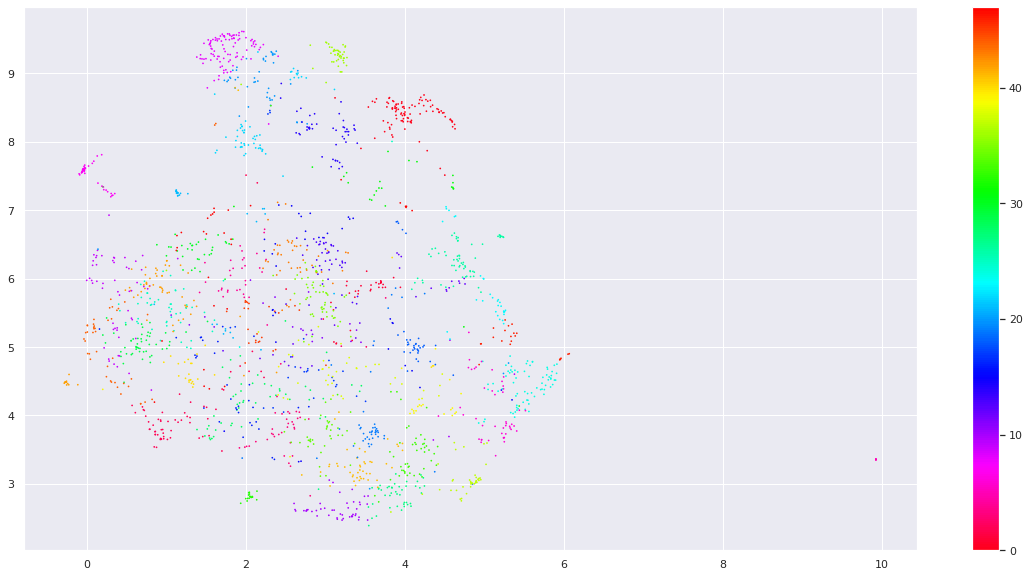

In [15]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
clustered = result.loc[result.labels != -1, :]
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [16]:
def frequency(l):
  d = {}
  for i in l:
    if i in d.keys():
        d[i] += 1
    else:
        d[i] = 1
  return d

In [17]:
coor = np.zeros((len(document_names),(cluster.labels_).max()+1))

In [18]:
for i in range(1,len(document_names)+1):
  f = (labels == i)*(cluster.labels_+1)
  p = frequency(f)
  del p[0]
  for key, value in p.items():
    coor[i-1,int(key)-1] = value
coor = coor/np.expand_dims(np.sum(coor,axis=1),axis=1)

In [19]:
lda_output_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42).fit_transform(coor)

In [20]:
x_coords = lda_output_svd[:, 0]
y_coords = lda_output_svd[:, 1]

In [23]:
clusters_dimreduced = KMeans(n_clusters=5).fit_predict(lda_output_svd)

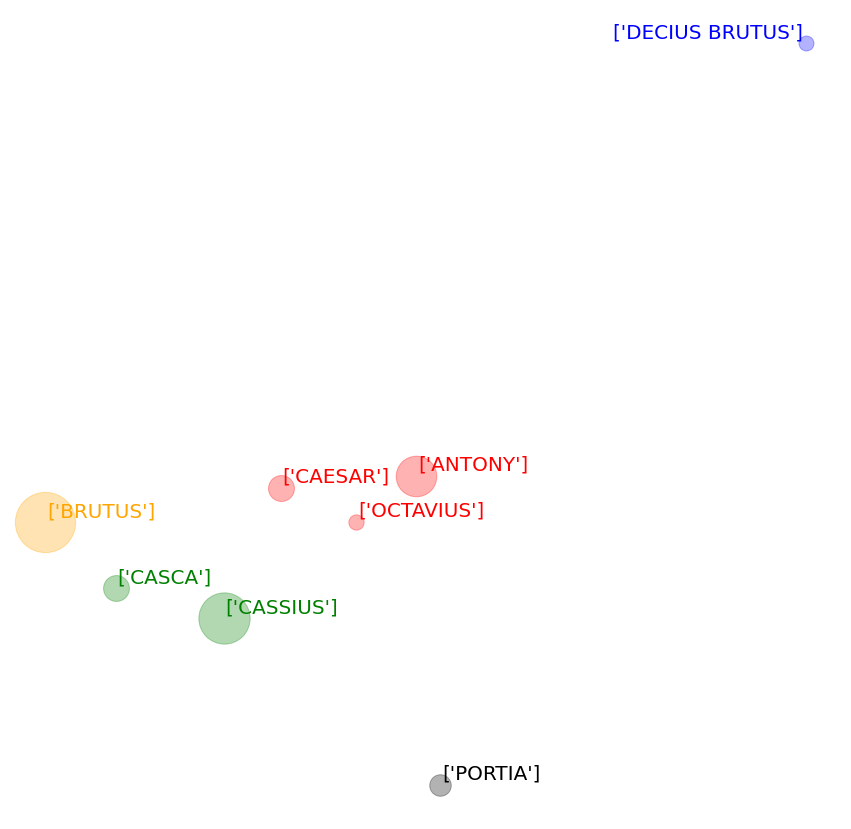

In [24]:
from adjustText import adjust_text

pyplot.figure(figsize=(15, 15))

pyplot.rcParams['axes.facecolor'] = 'white'
pyplot.axis('off')

a = 5
font_size = 20

for i,doc in enumerate(document_names):
    x = x_coords[i]
    y = y_coords[i]
    genre = doc[0][:-1]
    if clusters_dimreduced[i] == 0:
        pyplot.scatter(x, y, marker='o', color='red', alpha=0.3, s=a*lengths[i])
    elif clusters_dimreduced[i] == 1:
        pyplot.scatter(x, y, marker='o', color='blue', alpha=0.3, s=a*lengths[i])
    elif clusters_dimreduced[i] == 2:
        pyplot.scatter(x, y, marker='o', color='green', alpha=0.3, s=a*lengths[i])
    elif clusters_dimreduced[i] == 3:
        pyplot.scatter(x, y, marker='o', color='black', alpha=0.3, s=a*lengths[i])
    elif clusters_dimreduced[i] == 4:
        pyplot.scatter(x, y, marker='o', color='orange', alpha=0.3, s=a*lengths[i])
                
texts = []    
for i,doc in enumerate(document_names):
    x = x_coords[i]
    y = y_coords[i]
    doc = doc.split("-")
    if clusters_dimreduced[i] == 0:
        texts.append(pyplot.text(x, y, doc, fontsize=font_size, color="red"))
    elif clusters_dimreduced[i] == 1:
        texts.append(pyplot.text(x, y, doc, fontsize=font_size, color="blue"))
    elif clusters_dimreduced[i] == 2:
        texts.append(pyplot.text(x, y, doc, fontsize=font_size, color="green"))
    elif clusters_dimreduced[i] == 3:
        texts.append(pyplot.text(x, y, doc, fontsize=font_size, color="black"))
    elif clusters_dimreduced[i] == 4:
        texts.append(pyplot.text(x, y, doc, fontsize=font_size, color="orange"))

adjust_text(texts)        

pyplot.show()